<a href="https://colab.research.google.com/github/min0j98/mobis_ai_education_2025/blob/main/DL_07_GAN_BRKT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN (Generative Adversarial Networks)

- GAN : https://proceedings.neurips.cc/paper_files/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf

## 1. Load dataset

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/12_pMH77NyqSnp8NY0EFzZn1dODgrx_p8?usp=drive_link
!unzip dataset/data_2000.zip -d ./data2000

Retrieving folder contents
Processing file 1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6 data_500.zip
Processing file 1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY data_1000.zip
Processing file 12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj data_2000.zip
Processing file 1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF data_3000.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6
To: /content/dataset/data_500.zip
100% 567k/567k [00:00<00:00, 8.84MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY
To: /content/dataset/data_1000.zip
100% 1.20M/1.20M [00:00<00:00, 9.88MB/s]
Downloading...
From: https://drive.google.com/uc?id=12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj
To: /content/dataset/data_2000.zip
100% 2.27M/2.27M [00:00<00:00, 16.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF
To: /content/dataset/data_3000.zip
100% 3.31

## 2. Import python libraries and define util functions

In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset
from torch.utils.data.dataset import random_split
from torchvision.utils import save_image
from torchsummary import summary

import scipy.io
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# function to set seed
def set_seed(seed=42):
    # fix random seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # CuDNN setup
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# function to read and display images
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    plt.imshow(img, cmap='gray')
    plt.xticks([])  # x axis
    plt.yticks([])  # y axis
    plt.show()  # display the image
    return img

# function to read images
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    return img

# function to plot a line graph for loss history after model training
def plot_loss(g_loss, d_loss, title=None):

    plt.plot(g_loss)
    plt.plot(d_loss)
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Generator Loss', 'Discriminator Loss'], loc=0)
    # plt.show()

In [ ]:
set_seed(0)

## 3. Check dataset

In [ ]:
path = './data2000/23.119.jpg'
from PIL import Image
img = Image.open(path)
img.show()
img_array = np.array(img)
print(img_array.shape)

(56, 56)


## 4. Convert images into trainable data

In [ ]:
# image size = 56 x 56, 2000 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src = './data2000/'

# loop through the files, read each image, and normalize it (-1 to 1)
def get_data():
    files = os.listdir(src)  # get the list of files in the source directory
    X = []  # initialize empty lists for storing images

    for file in files:
        X.append((img_read(src,file)-127.5)/127.5)  # normalize the data between -1 and 1

    # split the data into 80% training set and 20% test set (test set can be considered as validation)
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=1,shuffle=True)

    # expand dimension to (batch_size, 1, height, width) in PyTorch
    X_train = np.expand_dims(X_train, axis=1)  # axis=1 for channel in PyTorch
    X_test = np.expand_dims(X_test, axis=1)  # same for test set

    return X_train, X_test

X_train, X_test = get_data()  # load data set (no y label needed as we only need images) / unsupervised learning

print("X_train.shape = {}".format(X_train.shape))
print("X_test.shape = {}".format(X_test.shape))

X_train.shape = (1600, 1, 56, 56)
X_test.shape = (400, 1, 56, 56)


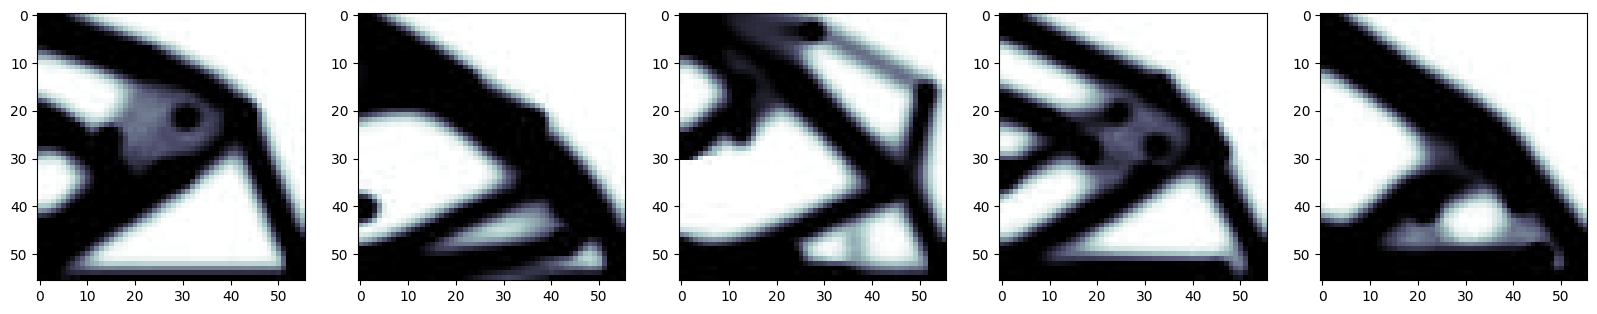

In [ ]:
# display images
fig = plt.figure(figsize=(20,10))
nplot = 5

for i in range(1,nplot+1):
    ax = fig.add_subplot(1,nplot,i)
    ax.imshow(X_train[i, 0, :, :],cmap = plt.cm.bone)
plt.show()

## 5. Set to model architecture

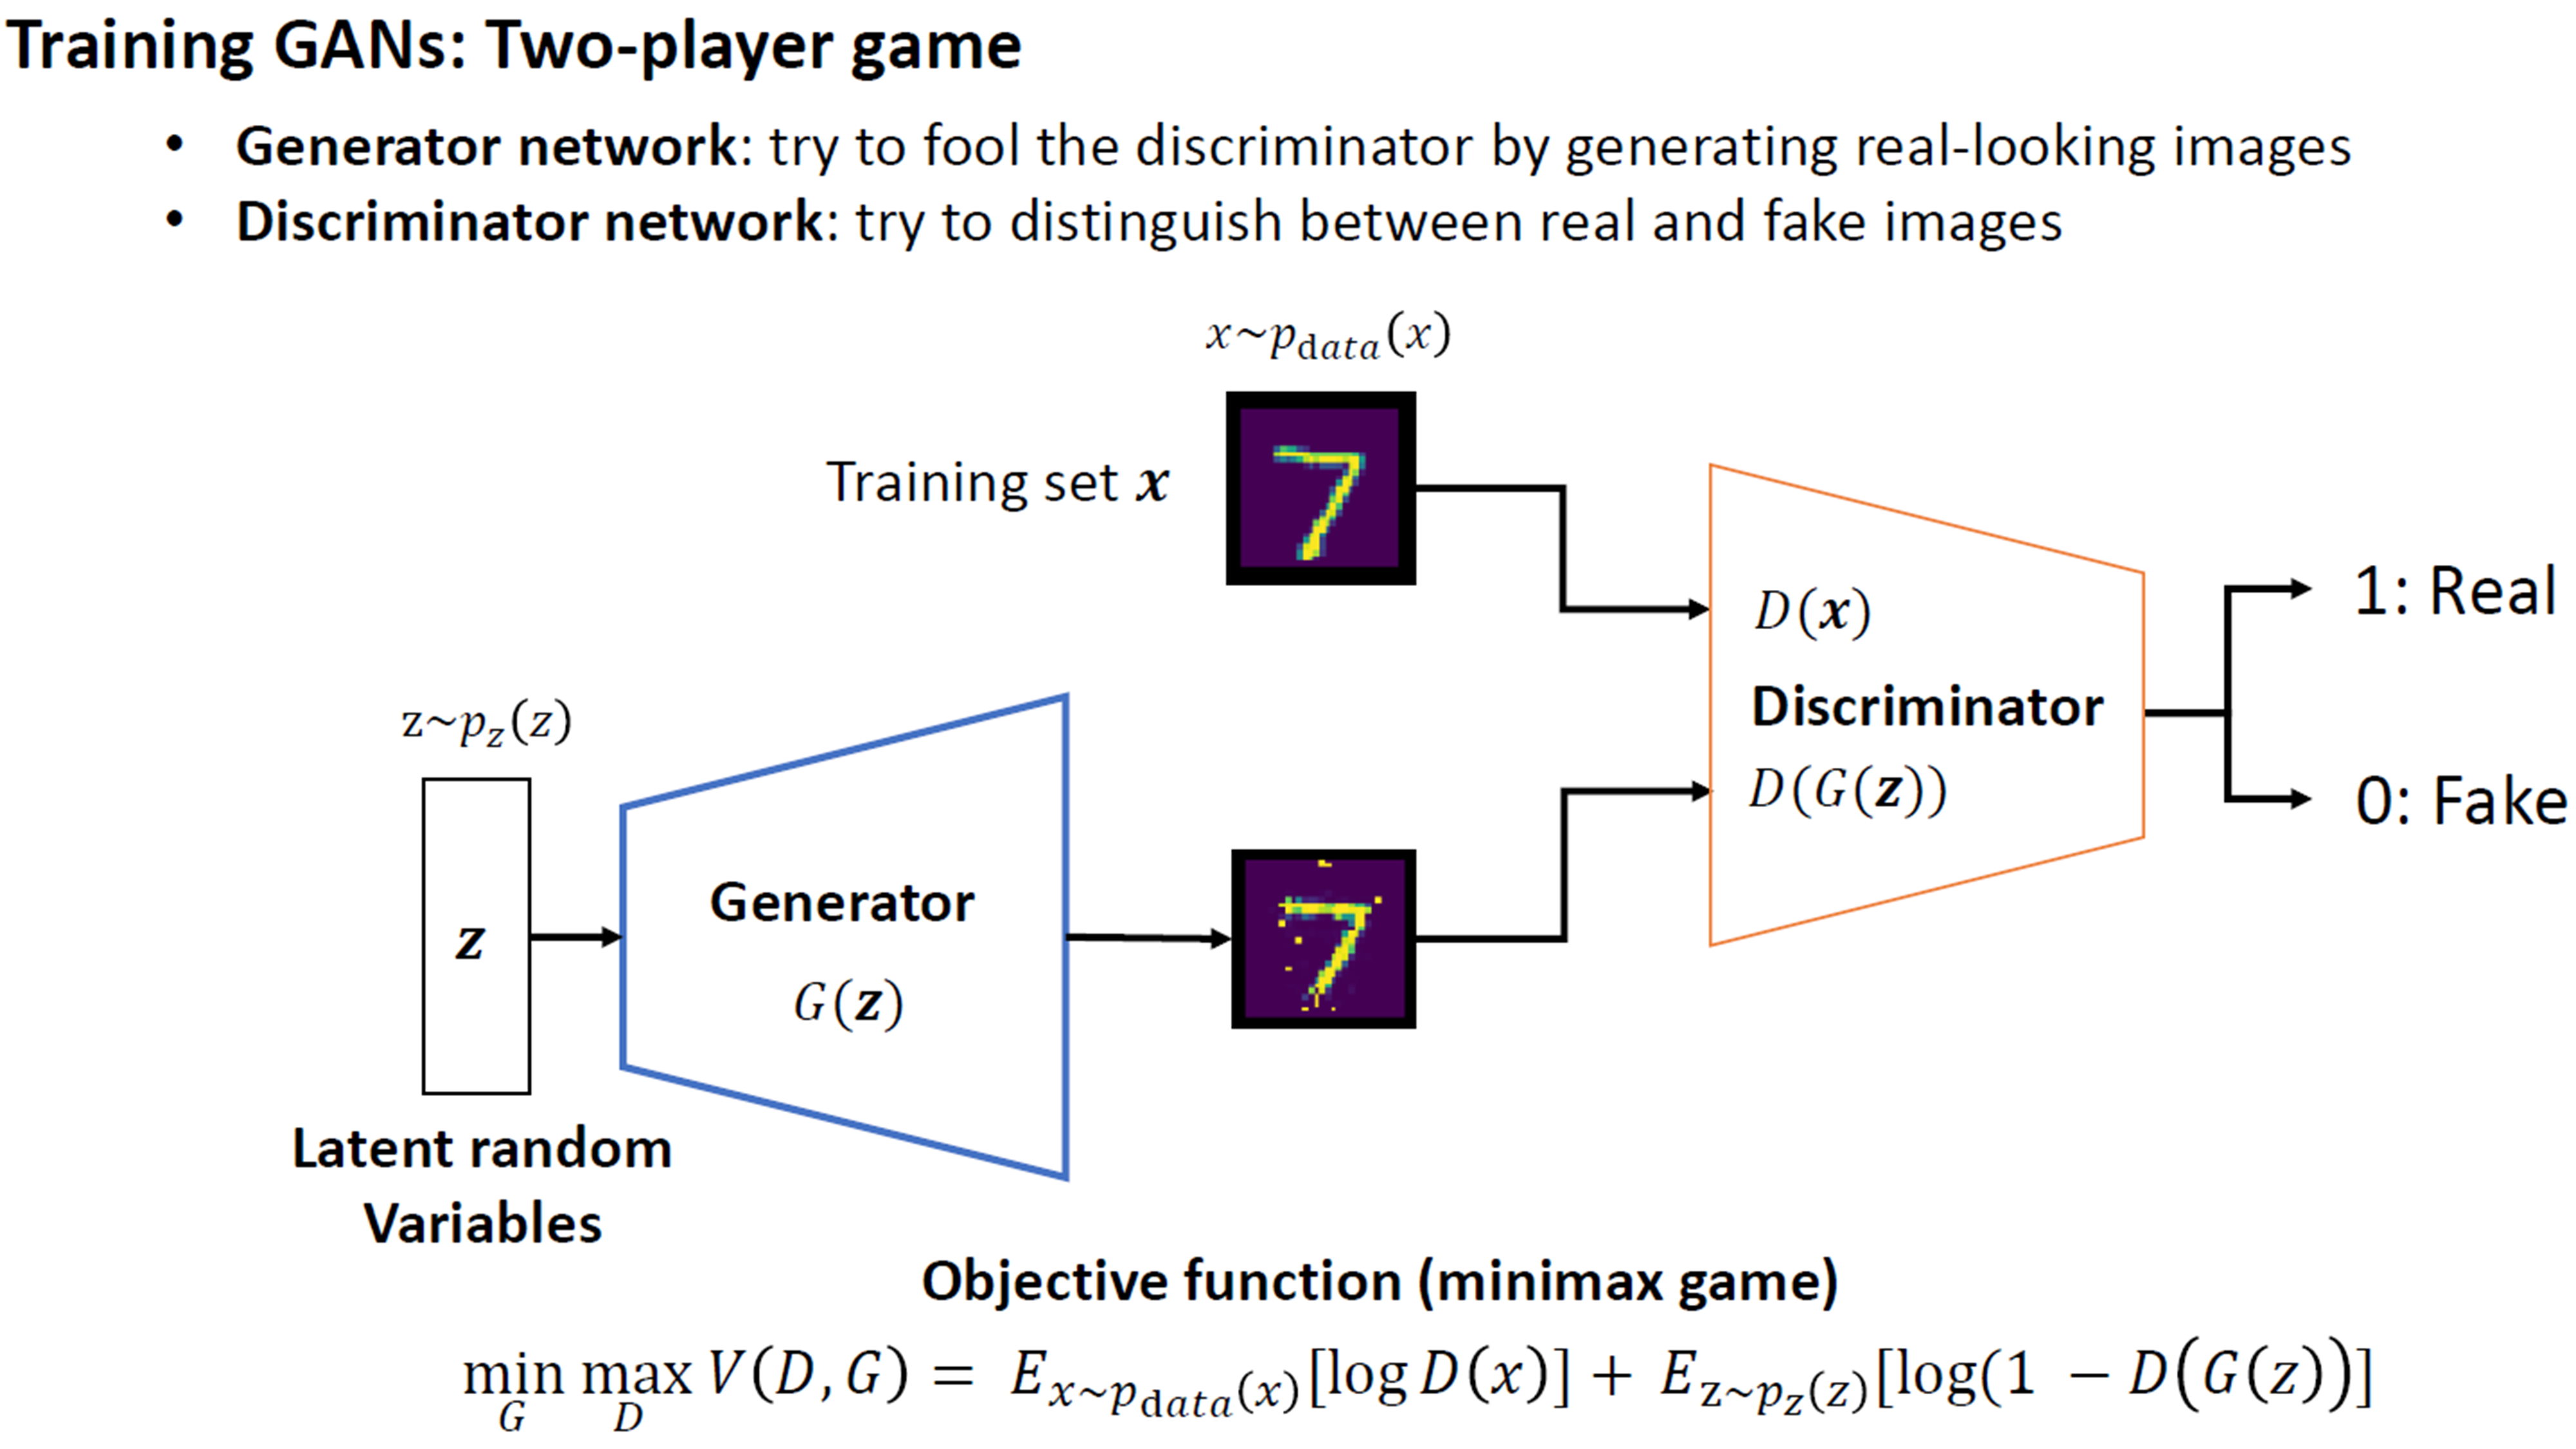

In [ ]:
class Generator(nn.Module):  # 가짜 이미지를 생성하는 모델
    def __init__(self):
        super(Generator, self).__init__()

        self.generator = nn.Sequential(
            nn.Linear(noise_size, hidden_size1),  # 랜덤 노이즈 → 첫 번째 은닉층
            nn.ReLU(),                           # 활성화 함수 (비선형성 추가)
            nn.Dropout(0.1),                     # 일부 뉴런 끄기 (과적합 방지)

            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(hidden_size3, img_size),   # 마지막 출력은 이미지 픽셀 크기와 같음
            nn.Tanh()  # [-1, 1] 범위 출력 (이미지 픽셀 값 정규화용)
        )

    def forward(self, x):
        gen = self.generator(x)  # 순전파 계산
        return gen


In [ ]:
class Discriminator(nn.Module):  # 진짜 이미지인지 가짜인지 구분하는 모델
    def __init__(self):
        super(Discriminator, self).__init__()

        self.discriminator = nn.Sequential(
            nn.Linear(img_size, hidden_size3),   # 이미지 벡터 → 첫 은닉층
            nn.LeakyReLU(0.2),                   # 음수도 살짝 통과시키는 ReLU 변형
            nn.Dropout(0.1),

            nn.Linear(hidden_size3, hidden_size2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),

            nn.Linear(hidden_size2, hidden_size1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),

            nn.Linear(hidden_size1, 1),          # 마지막 출력은 스칼라 (0~1 사이)
            nn.Sigmoid()                         # 확률 값으로 변환
        )

    def forward(self, x):
        dis = self.discriminator(x)  # 순전파 계산
        return dis


## 6. Set model hyperparameters

In [ ]:
# model architecture parameters
hidden_size1 = 64
hidden_size2 = 256
hidden_size3 = 784
noise_size = 100

# training parameters
learning_rate = 0.0002
batch_size = 32
num_epoch = 500

# fixed values
img_size = 56 * 56              # image size
num_channel = 1                 # grayscale images
img_shape = (num_channel,56,56) # grayscale images

## 7. Train model

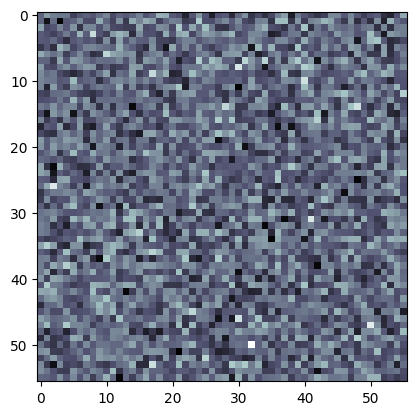

In [ ]:
# ---------------------------
# 1. 모델 정의 및 GPU 할당
# ---------------------------
generator = Generator().to(device)        # Generator를 GPU(or CPU)에 올림
discriminator = Discriminator().to(device) # Discriminator를 GPU(or CPU)에 올림


# ---------------------------
# 2. 데이터 준비
# ---------------------------
# 학습 이미지 데이터를 PyTorch Tensor로 변환
train_images = torch.tensor(X_train, dtype=torch.float32).to(device)
test_images = torch.tensor(X_test, dtype=torch.float32).to(device)

# DataLoader로 묶기 (batch 단위로 나눠서 모델에 공급)
# GAN은 label이 필요 없음 → TensorDataset(train_images)만 사용
train_dataset = TensorDataset(train_images)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# ---------------------------
# 3. 손실 함수 & 옵티마이저
# ---------------------------
criterion = nn.BCELoss()
# Binary Cross Entropy Loss:
# Discriminator 출력이 "진짜=1, 가짜=0"인 이진 분류 문제라서 BCE 사용

# Generator와 Discriminator 각각 Adam 옵티마이저로 학습
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)


# ---------------------------
# 4. Generator가 만든 가짜 이미지 확인
# ---------------------------
# torch.randn([1, 100]): 표준정규분포에서 랜덤 노이즈 벡터 생성 (길이=100)
generated_image = generator(torch.randn([1, 100]).to(device)).cpu().detach()

# 출력된 벡터를 56x56 이미지로 reshape해서 시각화
plt.imshow(torch.reshape(generated_image, (56,56)), cmap=plt.cm.bone)


# ---------------------------
# 5. 학습 과정 기록용 리스트 초기화
# ---------------------------
g_loss_history = []  # Generator 손실 기록
d_loss_history = []  # Discriminator 손실 기록


In [ ]:
# define fixed noise for visualization
fixed_noise = torch.randn(10, noise_size).to(device)  # 10 fixed noise vectors

# create a directory to save generated images
os.makedirs("./GAN_samples/", exist_ok=True)

Epoch [1/500]  D Loss: 0.5181  G Loss: 0.8888


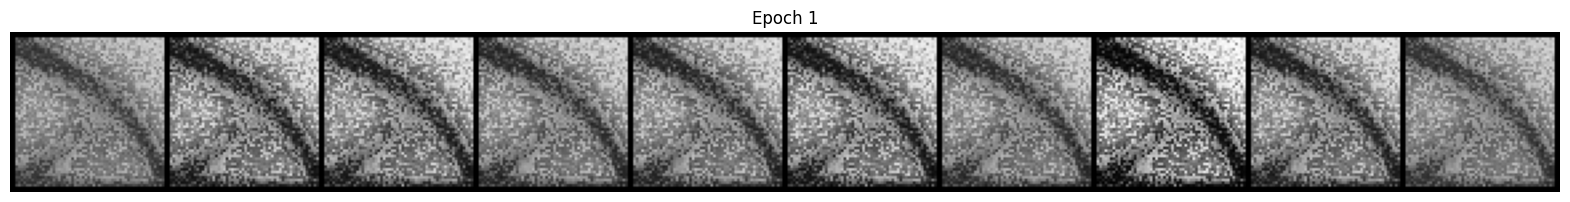

Epoch [2/500]  D Loss: 0.2075  G Loss: 1.6171
Epoch [3/500]  D Loss: 0.1386  G Loss: 2.0891
Epoch [4/500]  D Loss: 0.1813  G Loss: 3.1206
Epoch [5/500]  D Loss: 0.3770  G Loss: 1.9340
Epoch [6/500]  D Loss: 0.2388  G Loss: 1.9568
Epoch [7/500]  D Loss: 0.1453  G Loss: 3.4113
Epoch [8/500]  D Loss: 0.0906  G Loss: 4.2203
Epoch [9/500]  D Loss: 0.1289  G Loss: 4.0316
Epoch [10/500]  D Loss: 0.2603  G Loss: 2.7001
Epoch [11/500]  D Loss: 0.1277  G Loss: 3.1759
Epoch [12/500]  D Loss: 0.2131  G Loss: 3.3492
Epoch [13/500]  D Loss: 0.0690  G Loss: 4.2162
Epoch [14/500]  D Loss: 0.1345  G Loss: 3.9570
Epoch [15/500]  D Loss: 0.0536  G Loss: 4.2398
Epoch [16/500]  D Loss: 0.0583  G Loss: 4.5997
Epoch [17/500]  D Loss: 0.0470  G Loss: 5.1436
Epoch [18/500]  D Loss: 0.0752  G Loss: 5.1441
Epoch [19/500]  D Loss: 0.0997  G Loss: 4.5710
Epoch [20/500]  D Loss: 0.0756  G Loss: 4.7810
Epoch [21/500]  D Loss: 0.1147  G Loss: 3.9083
Epoch [22/500]  D Loss: 0.0487  G Loss: 4.2002
Epoch [23/500]  D Los

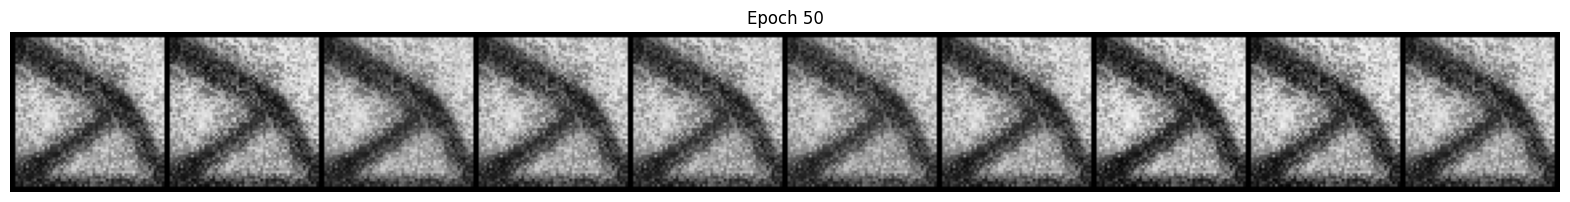

Epoch [51/500]  D Loss: 0.0404  G Loss: 6.1057
Epoch [52/500]  D Loss: 0.0543  G Loss: 9.1288
Epoch [53/500]  D Loss: 0.0978  G Loss: 6.5428
Epoch [54/500]  D Loss: 0.0746  G Loss: 5.5803
Epoch [55/500]  D Loss: 0.0389  G Loss: 6.0733
Epoch [56/500]  D Loss: 0.0489  G Loss: 5.4627
Epoch [57/500]  D Loss: 0.0661  G Loss: 4.8738
Epoch [58/500]  D Loss: 0.0547  G Loss: 5.5519
Epoch [59/500]  D Loss: 0.0610  G Loss: 7.0880
Epoch [60/500]  D Loss: 0.1378  G Loss: 6.5473
Epoch [61/500]  D Loss: 0.0464  G Loss: 7.4345
Epoch [62/500]  D Loss: 0.1171  G Loss: 7.5427
Epoch [63/500]  D Loss: 0.1076  G Loss: 7.3623
Epoch [64/500]  D Loss: 0.0961  G Loss: 5.2681
Epoch [65/500]  D Loss: 0.0783  G Loss: 4.4280
Epoch [66/500]  D Loss: 0.0328  G Loss: 5.4517
Epoch [67/500]  D Loss: 0.0585  G Loss: 5.6410
Epoch [68/500]  D Loss: 0.0502  G Loss: 5.5523
Epoch [69/500]  D Loss: 0.0427  G Loss: 5.4796
Epoch [70/500]  D Loss: 0.0401  G Loss: 6.8507
Epoch [71/500]  D Loss: 0.1140  G Loss: 8.0318
Epoch [72/500

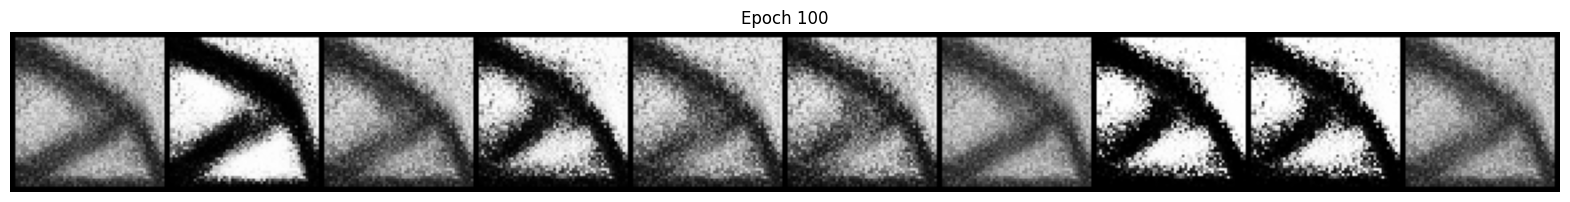

Epoch [101/500]  D Loss: 0.0655  G Loss: 5.5419
Epoch [102/500]  D Loss: 0.0996  G Loss: 7.3413
Epoch [103/500]  D Loss: 0.0905  G Loss: 4.8838
Epoch [104/500]  D Loss: 0.0430  G Loss: 5.1917
Epoch [105/500]  D Loss: 0.0384  G Loss: 5.6859
Epoch [106/500]  D Loss: 0.0489  G Loss: 5.8251
Epoch [107/500]  D Loss: 0.0609  G Loss: 5.4970
Epoch [108/500]  D Loss: 0.0943  G Loss: 5.3595
Epoch [109/500]  D Loss: 0.0568  G Loss: 5.0511
Epoch [110/500]  D Loss: 0.0674  G Loss: 5.3007
Epoch [111/500]  D Loss: 0.1046  G Loss: 6.4477
Epoch [112/500]  D Loss: 0.1225  G Loss: 5.9733
Epoch [113/500]  D Loss: 0.1211  G Loss: 4.6279
Epoch [114/500]  D Loss: 0.0835  G Loss: 5.3475
Epoch [115/500]  D Loss: 0.1003  G Loss: 5.4426
Epoch [116/500]  D Loss: 0.0817  G Loss: 5.9375
Epoch [117/500]  D Loss: 0.0853  G Loss: 4.8796
Epoch [118/500]  D Loss: 0.0615  G Loss: 5.3230
Epoch [119/500]  D Loss: 0.1166  G Loss: 4.7244
Epoch [120/500]  D Loss: 0.0655  G Loss: 5.1785
Epoch [121/500]  D Loss: 0.1215  G Loss:

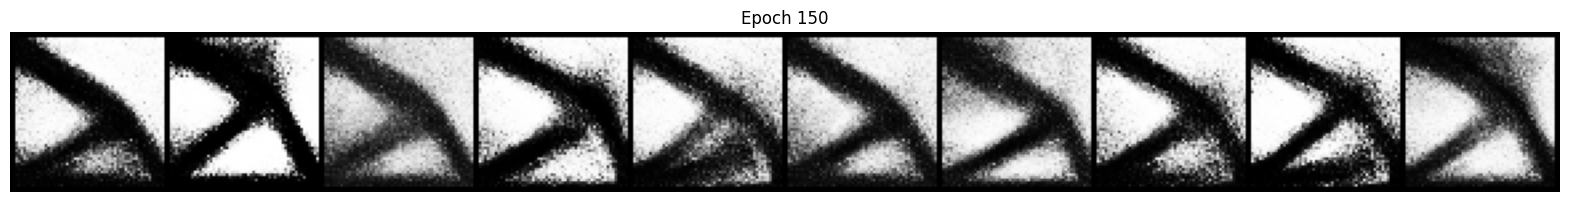

Epoch [151/500]  D Loss: 0.0994  G Loss: 4.1786
Epoch [152/500]  D Loss: 0.0987  G Loss: 4.5739
Epoch [153/500]  D Loss: 0.1214  G Loss: 4.0712
Epoch [154/500]  D Loss: 0.0840  G Loss: 4.9959
Epoch [155/500]  D Loss: 0.1478  G Loss: 4.1986
Epoch [156/500]  D Loss: 0.1491  G Loss: 4.5729
Epoch [157/500]  D Loss: 0.1525  G Loss: 4.1857
Epoch [158/500]  D Loss: 0.1322  G Loss: 4.0697
Epoch [159/500]  D Loss: 0.0919  G Loss: 4.4534
Epoch [160/500]  D Loss: 0.1291  G Loss: 4.1795
Epoch [161/500]  D Loss: 0.1073  G Loss: 4.3971
Epoch [162/500]  D Loss: 0.0885  G Loss: 4.7904
Epoch [163/500]  D Loss: 0.1345  G Loss: 4.6844
Epoch [164/500]  D Loss: 0.1200  G Loss: 4.2270
Epoch [165/500]  D Loss: 0.1181  G Loss: 4.1347
Epoch [166/500]  D Loss: 0.1138  G Loss: 5.0270
Epoch [167/500]  D Loss: 0.1536  G Loss: 4.0441
Epoch [168/500]  D Loss: 0.1365  G Loss: 4.4169
Epoch [169/500]  D Loss: 0.1012  G Loss: 4.1860
Epoch [170/500]  D Loss: 0.1270  G Loss: 4.1832
Epoch [171/500]  D Loss: 0.1218  G Loss:

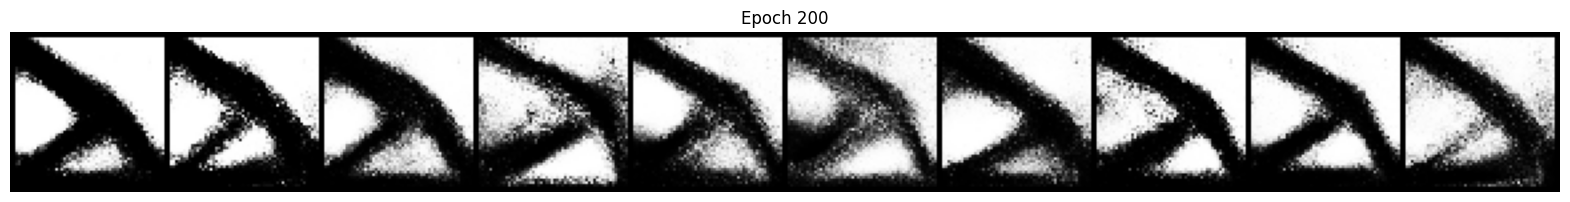

Epoch [201/500]  D Loss: 0.1427  G Loss: 3.8384
Epoch [202/500]  D Loss: 0.1475  G Loss: 3.9928
Epoch [203/500]  D Loss: 0.1883  G Loss: 4.0316
Epoch [204/500]  D Loss: 0.1535  G Loss: 3.7603
Epoch [205/500]  D Loss: 0.1350  G Loss: 3.6302
Epoch [206/500]  D Loss: 0.1516  G Loss: 3.7752
Epoch [207/500]  D Loss: 0.1771  G Loss: 3.8375
Epoch [208/500]  D Loss: 0.1612  G Loss: 3.6229
Epoch [209/500]  D Loss: 0.1942  G Loss: 3.7208
Epoch [210/500]  D Loss: 0.1416  G Loss: 3.7502
Epoch [211/500]  D Loss: 0.1717  G Loss: 3.6567
Epoch [212/500]  D Loss: 0.1510  G Loss: 3.8598
Epoch [213/500]  D Loss: 0.1921  G Loss: 3.5994
Epoch [214/500]  D Loss: 0.1553  G Loss: 4.1388
Epoch [215/500]  D Loss: 0.1663  G Loss: 3.9359
Epoch [216/500]  D Loss: 0.1374  G Loss: 3.9354
Epoch [217/500]  D Loss: 0.1555  G Loss: 4.1052
Epoch [218/500]  D Loss: 0.1429  G Loss: 4.1659
Epoch [219/500]  D Loss: 0.1380  G Loss: 4.0739
Epoch [220/500]  D Loss: 0.1548  G Loss: 3.8902
Epoch [221/500]  D Loss: 0.1529  G Loss:

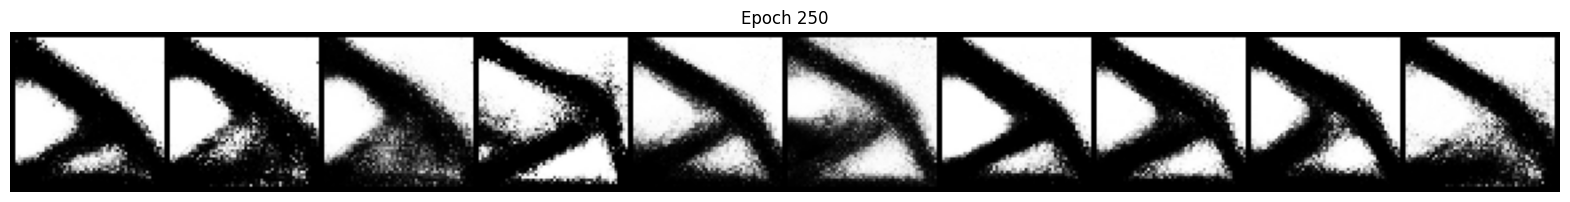

Epoch [251/500]  D Loss: 0.1904  G Loss: 3.3534
Epoch [252/500]  D Loss: 0.1698  G Loss: 3.6434
Epoch [253/500]  D Loss: 0.1634  G Loss: 3.5487
Epoch [254/500]  D Loss: 0.1727  G Loss: 3.4454
Epoch [255/500]  D Loss: 0.2014  G Loss: 3.4939
Epoch [256/500]  D Loss: 0.1727  G Loss: 3.4403
Epoch [257/500]  D Loss: 0.1674  G Loss: 3.6953
Epoch [258/500]  D Loss: 0.2286  G Loss: 3.3895
Epoch [259/500]  D Loss: 0.1853  G Loss: 3.5746
Epoch [260/500]  D Loss: 0.1777  G Loss: 3.6078
Epoch [261/500]  D Loss: 0.2189  G Loss: 3.2613
Epoch [262/500]  D Loss: 0.2158  G Loss: 3.5846
Epoch [263/500]  D Loss: 0.1889  G Loss: 3.2639
Epoch [264/500]  D Loss: 0.1861  G Loss: 3.4211
Epoch [265/500]  D Loss: 0.1970  G Loss: 3.3536
Epoch [266/500]  D Loss: 0.1630  G Loss: 3.5031
Epoch [267/500]  D Loss: 0.2184  G Loss: 3.4125
Epoch [268/500]  D Loss: 0.1974  G Loss: 3.4129
Epoch [269/500]  D Loss: 0.1523  G Loss: 3.9004
Epoch [270/500]  D Loss: 0.1985  G Loss: 3.5453
Epoch [271/500]  D Loss: 0.1823  G Loss:

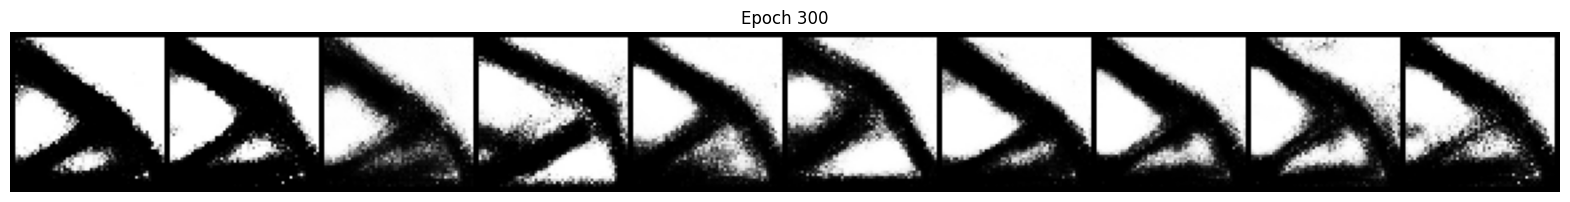

Epoch [301/500]  D Loss: 0.2037  G Loss: 3.0861
Epoch [302/500]  D Loss: 0.1813  G Loss: 3.4386
Epoch [303/500]  D Loss: 0.1658  G Loss: 3.7576
Epoch [304/500]  D Loss: 0.2211  G Loss: 3.4219
Epoch [305/500]  D Loss: 0.2200  G Loss: 3.3399
Epoch [306/500]  D Loss: 0.1771  G Loss: 3.4706
Epoch [307/500]  D Loss: 0.2082  G Loss: 3.3388
Epoch [308/500]  D Loss: 0.2095  G Loss: 3.1128
Epoch [309/500]  D Loss: 0.2049  G Loss: 3.2869
Epoch [310/500]  D Loss: 0.1699  G Loss: 3.7070
Epoch [311/500]  D Loss: 0.1926  G Loss: 3.5587
Epoch [312/500]  D Loss: 0.2000  G Loss: 3.2679
Epoch [313/500]  D Loss: 0.2142  G Loss: 3.3885
Epoch [314/500]  D Loss: 0.2077  G Loss: 3.3184
Epoch [315/500]  D Loss: 0.1997  G Loss: 3.4709
Epoch [316/500]  D Loss: 0.2042  G Loss: 3.2714
Epoch [317/500]  D Loss: 0.2281  G Loss: 3.4525
Epoch [318/500]  D Loss: 0.2444  G Loss: 3.0254
Epoch [319/500]  D Loss: 0.1721  G Loss: 3.2650
Epoch [320/500]  D Loss: 0.2198  G Loss: 3.2393
Epoch [321/500]  D Loss: 0.2213  G Loss:

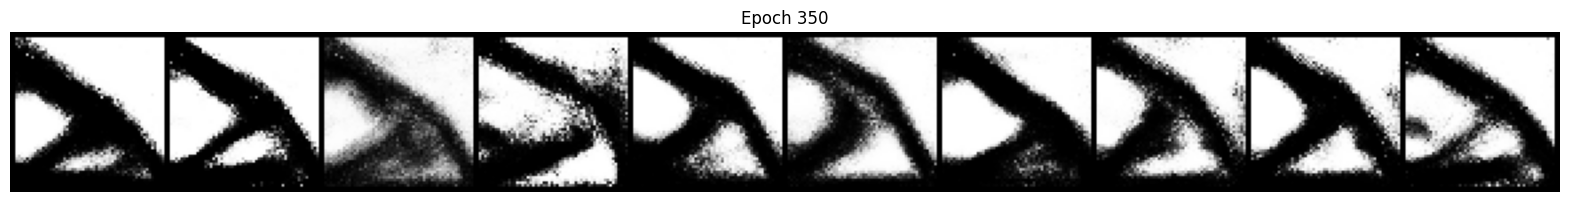

Epoch [351/500]  D Loss: 0.2037  G Loss: 3.2027
Epoch [352/500]  D Loss: 0.2401  G Loss: 3.1649
Epoch [353/500]  D Loss: 0.2218  G Loss: 3.1364
Epoch [354/500]  D Loss: 0.2126  G Loss: 3.3203
Epoch [355/500]  D Loss: 0.2408  G Loss: 2.9768
Epoch [356/500]  D Loss: 0.2195  G Loss: 3.0888
Epoch [357/500]  D Loss: 0.2495  G Loss: 3.0566
Epoch [358/500]  D Loss: 0.1914  G Loss: 3.1597
Epoch [359/500]  D Loss: 0.2224  G Loss: 2.8861
Epoch [360/500]  D Loss: 0.2358  G Loss: 3.0977
Epoch [361/500]  D Loss: 0.2196  G Loss: 3.4370
Epoch [362/500]  D Loss: 0.2020  G Loss: 3.4111
Epoch [363/500]  D Loss: 0.2012  G Loss: 3.4404
Epoch [364/500]  D Loss: 0.2358  G Loss: 3.1743
Epoch [365/500]  D Loss: 0.2232  G Loss: 3.2486
Epoch [366/500]  D Loss: 0.2291  G Loss: 3.3392
Epoch [367/500]  D Loss: 0.2352  G Loss: 3.2544
Epoch [368/500]  D Loss: 0.2192  G Loss: 3.0797
Epoch [369/500]  D Loss: 0.1921  G Loss: 3.2611
Epoch [370/500]  D Loss: 0.2598  G Loss: 3.1558
Epoch [371/500]  D Loss: 0.2656  G Loss:

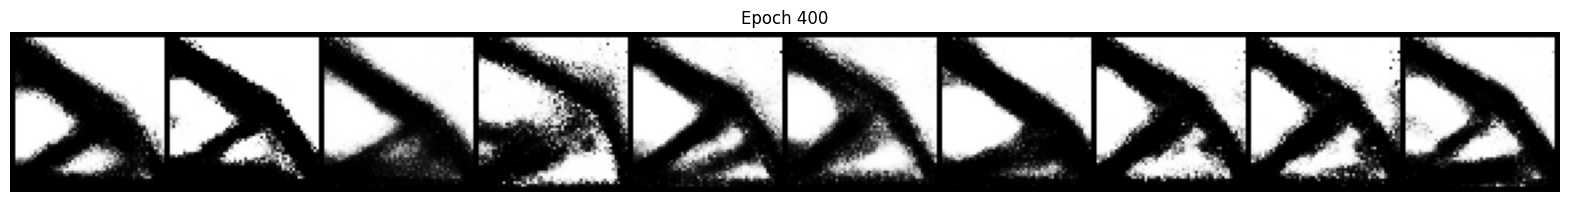

Epoch [401/500]  D Loss: 0.2283  G Loss: 3.4126
Epoch [402/500]  D Loss: 0.2303  G Loss: 3.1555
Epoch [403/500]  D Loss: 0.2527  G Loss: 2.8863
Epoch [404/500]  D Loss: 0.1920  G Loss: 3.2451
Epoch [405/500]  D Loss: 0.2373  G Loss: 2.9958
Epoch [406/500]  D Loss: 0.2505  G Loss: 3.0830
Epoch [407/500]  D Loss: 0.2078  G Loss: 3.3307
Epoch [408/500]  D Loss: 0.2005  G Loss: 3.1230
Epoch [409/500]  D Loss: 0.2545  G Loss: 2.7857
Epoch [410/500]  D Loss: 0.2473  G Loss: 3.0578
Epoch [411/500]  D Loss: 0.2037  G Loss: 3.3594
Epoch [412/500]  D Loss: 0.2274  G Loss: 3.0523
Epoch [413/500]  D Loss: 0.1994  G Loss: 3.5614
Epoch [414/500]  D Loss: 0.2758  G Loss: 3.0994
Epoch [415/500]  D Loss: 0.2332  G Loss: 3.2745
Epoch [416/500]  D Loss: 0.2201  G Loss: 3.1211
Epoch [417/500]  D Loss: 0.2407  G Loss: 3.1101
Epoch [418/500]  D Loss: 0.2204  G Loss: 3.3724
Epoch [419/500]  D Loss: 0.2278  G Loss: 3.2462
Epoch [420/500]  D Loss: 0.2245  G Loss: 3.3462
Epoch [421/500]  D Loss: 0.2353  G Loss:

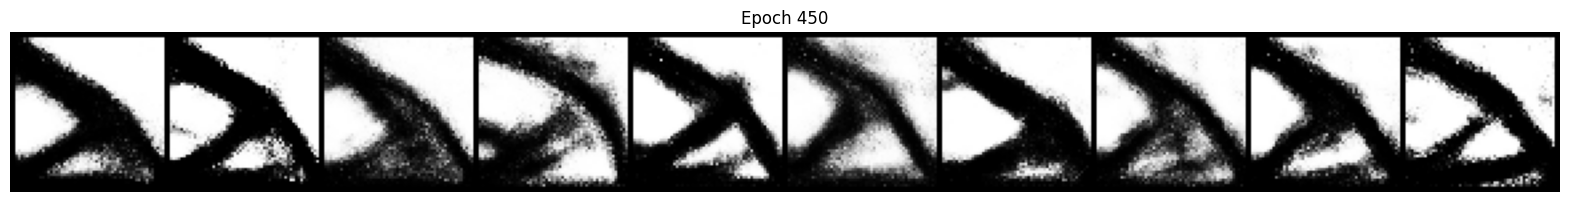

Epoch [451/500]  D Loss: 0.2127  G Loss: 3.2797
Epoch [452/500]  D Loss: 0.2254  G Loss: 3.2877
Epoch [453/500]  D Loss: 0.2345  G Loss: 3.2027
Epoch [454/500]  D Loss: 0.2158  G Loss: 3.5360
Epoch [455/500]  D Loss: 0.2154  G Loss: 3.2875
Epoch [456/500]  D Loss: 0.2223  G Loss: 3.3002
Epoch [457/500]  D Loss: 0.2249  G Loss: 3.1236
Epoch [458/500]  D Loss: 0.2058  G Loss: 3.3659
Epoch [459/500]  D Loss: 0.1803  G Loss: 3.5414
Epoch [460/500]  D Loss: 0.2590  G Loss: 3.2502
Epoch [461/500]  D Loss: 0.2359  G Loss: 3.2196
Epoch [462/500]  D Loss: 0.2242  G Loss: 3.1985
Epoch [463/500]  D Loss: 0.1793  G Loss: 3.5464
Epoch [464/500]  D Loss: 0.2369  G Loss: 3.2878
Epoch [465/500]  D Loss: 0.2333  G Loss: 3.1444
Epoch [466/500]  D Loss: 0.2053  G Loss: 3.4478
Epoch [467/500]  D Loss: 0.2147  G Loss: 3.2950
Epoch [468/500]  D Loss: 0.2037  G Loss: 3.5275
Epoch [469/500]  D Loss: 0.2233  G Loss: 3.5331
Epoch [470/500]  D Loss: 0.2352  G Loss: 3.1522
Epoch [471/500]  D Loss: 0.2409  G Loss:

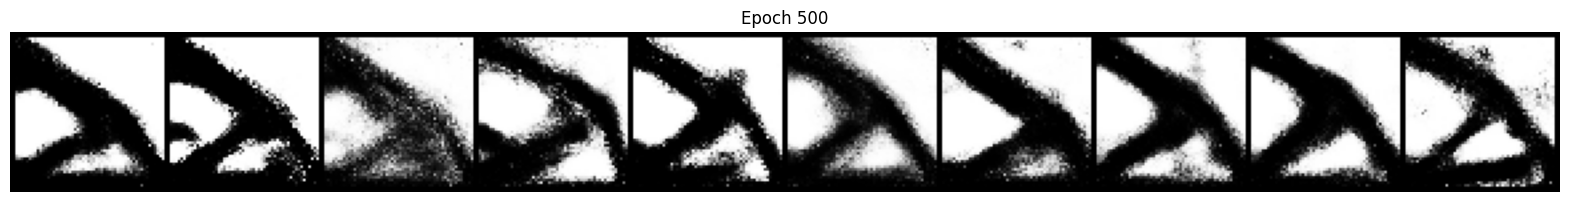

In [ ]:
"""
Training part
"""
for epoch in range(1, num_epoch + 1):

    total_g_loss = 0.0  # 한 epoch 동안 Generator 손실 누적
    total_d_loss = 0.0  # 한 epoch 동안 Discriminator 손실 누적

    # train_loader에서 batch 단위로 학습
    for i, (images,) in enumerate(train_loader):

        # --------------------------
        # 1. 진짜/가짜 라벨 만들기
        # --------------------------
        real_label = torch.full((batch_size, 1), 1, dtype=torch.float32).to(device)  # 진짜 = 1
        fake_label = torch.full((batch_size, 1), 0, dtype=torch.float32).to(device)  # 가짜 = 0

        # 진짜 이미지를 (batch_size, 56*56) 형태로 펴주기
        real_images = images.reshape(batch_size, -1)


        # ====================================
        #   (A) Discriminator 학습 단계
        # ====================================
        # Generator로 가짜 이미지 만들기
        z = torch.randn(batch_size, noise_size).to(device)  # 랜덤 노이즈 생성
        fake_images = generator(z)  # 가짜 이미지 생성

        d_optimizer.zero_grad()  # Discriminator gradient 초기화

        # Discriminator가 fake_images(가짜) 보고 예측한 값 → fake_loss
        fake_loss = criterion(discriminator(fake_images.detach()), fake_label)

        # Discriminator가 real_images(진짜) 보고 예측한 값 → real_loss
        real_loss = criterion(discriminator(real_images), real_label)

        # Discriminator의 최종 손실 = (진짜 판별 손실 + 가짜 판별 손실)/2
        d_loss = (fake_loss + real_loss) / 2

        # 역전파 & 가중치 업데이트
        d_loss.backward()
        d_optimizer.step()

        total_d_loss += d_loss.item()  # 손실 누적


        # ====================================
        #   (B) Generator 학습 단계
        # ====================================
        g_optimizer.zero_grad()  # Generator gradient 초기화

        # Generator가 새 가짜 이미지 생성
        z = torch.randn(batch_size, noise_size).to(device)
        fake_images = generator(z)

        # Generator 입장: "내가 만든 가짜를 Discriminator가 진짜(=1)라고 믿게 하고 싶다"
        g_loss = criterion(discriminator(fake_images), real_label)

        # 역전파 & 가중치 업데이트
        g_loss.backward()
        g_optimizer.step()

        total_g_loss += g_loss.item()  # 손실 누적


    # --------------------------
    # 2. 한 epoch이 끝난 후 평균 손실 계산
    # --------------------------
    avg_g_loss = total_g_loss / len(train_loader)
    avg_d_loss = total_d_loss / len(train_loader)

    g_loss_history.append(avg_g_loss)
    d_loss_history.append(avg_d_loss)

    print(f"Epoch [{epoch}/{num_epoch}]  D Loss: {avg_d_loss:.4f}  G Loss: {avg_g_loss:.4f}")


    # --------------------------
    # 3. 주기적으로 결과 시각화 & 모델 저장
    # --------------------------
    if epoch % 50 == 0 or epoch == 1:
        with torch.no_grad():
            fake_images = generator(fixed_noise).detach().cpu()
        fake_images = fake_images.view(-1, 1, 56, 56)

        # 생성된 이미지들을 10x10 격자(grid)로 저장
        save_image(fake_images, f"./GAN_samples/GAN_epoch_{epoch}.png", nrow=10, normalize=True)

        # 이미지 직접 출력
        plt.figure(figsize=(20, 4))
        img = plt.imread(f"./GAN_samples/GAN_epoch_{epoch}.png")
        plt.imshow(img)
        plt.title(f"Epoch {epoch}")
        plt.axis('off')
        plt.show()

        # 50 epoch마다 Generator/Discriminator 가중치 저장
        if epoch % 50 == 0 or epoch == num_epoch:
            torch.save(generator.state_dict(), f"./GAN_samples/generator_epoch_{epoch}.pth")
            torch.save(discriminator.state_dict(), f"./GAN_samples/discriminator_epoch_{epoch}.pth")


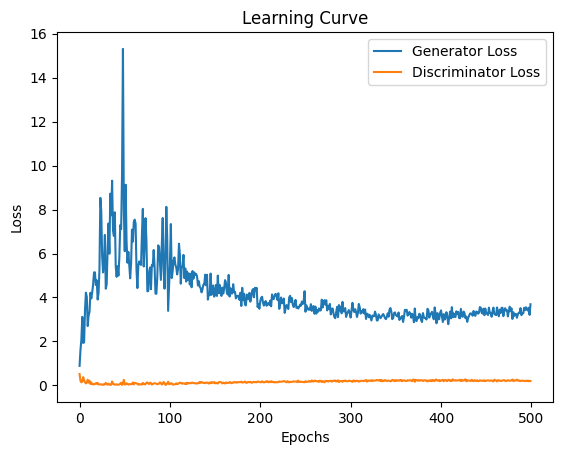

In [ ]:
# graph visualization
plot_loss(g_loss_history, d_loss_history, 'Learning Curve')  # loss variation over epochs during training
plt.show()

## 8. Load & Evaluate model

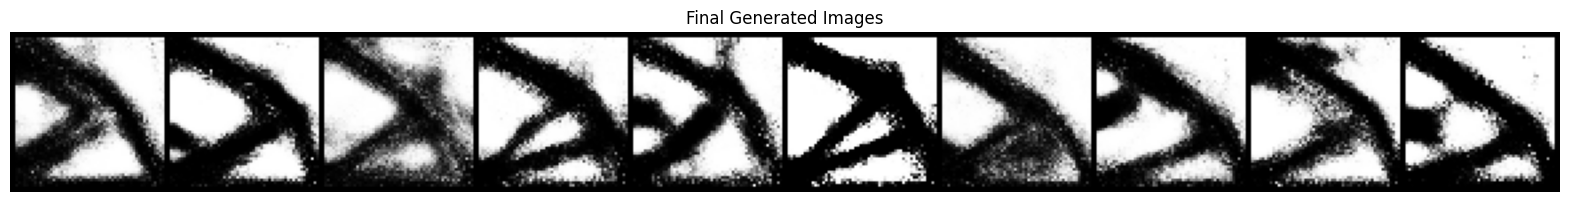

In [ ]:
# final Image Generation and Visualization after training
with torch.no_grad():
    final_noise = torch.randn(10, noise_size).to(device)
    final_fake_images = generator(final_noise).cpu()
    final_fake_images = final_fake_images.view(-1, 1, 56, 56)
    save_image(final_fake_images, f"./GAN_samples/GAN_final.png", nrow=10, normalize=True)

# display the final generated images
plt.figure(figsize=(20, 4))
img = plt.imread("./GAN_samples/GAN_final.png")
plt.imshow(img)
plt.title("Final Generated Images")
plt.axis('off')
plt.show()